# Recurrent Neural Network Implementation from Scratch

\Assume that we have
a minibatch of inputs
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
at time step $t$.
In other words,
for a minibatch of $n$ sequence examples,
each row of $\mathbf{X}_t$ corresponds to one example at time step $t$ from the sequence.
Next,
denote by $\mathbf{H}_t  \in \mathbb{R}^{n \times h}$ the hidden layer output of time step $t$.
Unlike the MLP, here we save the hidden layer output $\mathbf{H}_{t-1}$ from the previous time step and introduce a new weight parameter $\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$ to describe how to use the hidden layer output of the previous time step in the current time step. Specifically, the calculation of the hidden layer output of the current time step is determined by the input of the current time step together with the hidden layer output of the previous time step:

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h).$$
:eqlabel:`rnn_h_with_state`

From the relationship between hidden layer outputs $\mathbf{H}_t$ and $\mathbf{H}_{t-1}$ of adjacent time steps,
we know that these variables captured and retained the sequence's historical information up to their current time step, just like the state or memory of the neural network's current time step. Therefore, such a hidden layer output is called a *hidden state*.
Since the hidden state uses the same definition of the previous time step in the current time step, the computation of :eqref:`rnn_h_with_state` is *recurrent*. Hence, as we said, neural networks with hidden states
based on recurrent computation are named
*recurrent neural networks*.
Layers that perform
the computation of :eqref:`rnn_h_with_state`
in RNNs
are called *recurrent layers*.


There are many different ways for constructing RNNs.
RNNs with a hidden state defined by :eqref:`rnn_h_with_state` are very common.
For time step $t$,
the output of the output layer is similar to the computation in the MLP:

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

Parameters of the RNN
include the weights $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$,
and the bias $\mathbf{b}_h \in \mathbb{R}^{1 \times h}$
of the hidden layer,
together with the weights $\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$
and the bias $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$
of the output layer.
It is worth mentioning that
even at different time steps,
RNNs always use these model parameters.
Therefore, the parameterization cost of an RNN
does not grow as the number of time steps increases.

At any time step $t$,
the computation of the hidden state can be treated as:
(i) concatenating the input $\mathbf{X}_t$ at the current time step $t$ and the hidden state $\mathbf{H}_{t-1}$ at the previous time step $t-1$;
(ii) feeding the concatenation result into a fully connected layer with the activation function $\phi$.
The output of such a fully connected layer is the hidden state $\mathbf{H}_t$ of the current time step $t$.
In this case,
the model parameters are the concatenation of $\mathbf{W}_{xh}$ and $\mathbf{W}_{hh}$, and a bias of $\mathbf{b}_h$, all from :eqref:`rnn_h_with_state`.
The hidden state of the current time step $t$, $\mathbf{H}_t$, will participate in computing the hidden state $\mathbf{H}_{t+1}$ of the next time step $t+1$.
What is more, $\mathbf{H}_t$ will also be
fed into the fully connected output layer
to compute the output
$\mathbf{O}_t$ of the current time step $t$.



We just mentioned that the calculation of $\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}$ for the hidden state is equivalent to
matrix multiplication of
concatenation of $\mathbf{X}_t$ and $\mathbf{H}_{t-1}$
and
concatenation of $\mathbf{W}_{xh}$ and $\mathbf{W}_{hh}$.

We are now ready to implement an RNN from scratch.
In particular, we will train this RNN to function
as a character-level language model
and train it on a corpus consisting of 
the entire text of H. G. Wells' *The Time Machine*.
We start by loading the dataset.

In [2]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35 # num_steps: length of text sequence
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### One-Hot Encoding

Recall that each token is represented 
by a numerical index indicating the
position in the vocabulary of the 
corresponding word/character/word-piece.
You might be tempted to build a neural network
with a single input node (at each time step),
where the index could be fed in as a scalar value.
This works when we are dealing with numerical inputs 
like price or temperature, where any two values
sufficiently close together
should be treated similarly.
But this doesn't quite make sense. 
The $45^{\mathrm{th}}$ and $46^{\mathrm{th}}$ words 
in our vocabulary happen to be "their" and "said",
whose meanings are not remotely similar.

When dealing with such categorical data,
the most common strategy is to represent
each item by a *one-hot encoding*.
A one-hot encoding is a vector whose length
is given by the size of the vocabulary $N$,
where all entries are set to $0$,
except for the entry corresponding 
to our token, which is set to $1$.
For example, if the vocabulary had 5 elements,
then the one-hot vectors corresponding 
to indices 0 and 2 would be the following.


In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

**The minibatches that we sample at each iteration
will take the shape (batch size, number of time steps).
Once representing each input as a one-hot vector,
we can think of each minibatch as a three-dimensional tensor, 
where the length along the third axis 
is given by the vocabulary size (`len(vocab)`).**
We often transpose the input so that we will obtain an output 
of shape (number of time steps, batch size, vocabulary size).
This will allow us to more conveniently
loop through the outermost dimension
for updating hidden states of a minibatch,
time step by time step.

In [4]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, len(vocab)).shape # (number of time steps, batch size, vocabulary size)

torch.Size([5, 2, 28])

**Initialize model parameters**

In [5]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    # parameters of hidden layer 
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # parameters of output layer
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # gradient
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

**Initialize hidden states**

In [6]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), ) # NOTE: hidden state is a tuple with one item

Compute hidden states and outputs.
The codes below defines how to compute 
the output and hidden state at any time step,
given the current input and the state of the model
at the previous time step.
Note that the RNN model loops through 
the outermost dimension of `inputs`,
updating the hidden state 
one time step at a time.
The model here uses a $\tanh$ activation function.

In [7]:
def rnn(inputs, state, params):
    # intput shape: (num_steps, batch_size, len(vocab))
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state # NOTE: hidden state is a tuple with one item
    outputs = []
    # shape of X: (batch_size, len(vocab))
    for X in inputs: # iterate over time steps
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,) # after torch.cat, (batch_size*num_steps, len(vocab))

Put all together in a class. Note that the number of hidden units num_hiddens is a tunable hyperparameter.

In [8]:
class RNNModelScratch: 
    """RNN implementation from scrach"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state): # shape of X: (batch_size, len(vocab))
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32) 
        return self.forward_fn(X, state, self.params) # shape of X: (num_steps, batch_size, len(vocab))

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

Let's check whether the RNN model produces results of the correct shapes to ensure that the dimensionality of the hidden state remains unchanged.

In [9]:
num_hiddens = 512 # number of hidden states is a hypterparameter
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
# feed a minibatch of input sequences into an RNN model as follows.
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape
# Y: (num_steps, len(vocab))
# new_state: a tuple with only one item
# new_state[0]: (batch_size, len(vocab))

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

### Prediction

In [10]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """Generate new characters after prefix"""
    state = net.begin_state(batch_size=1, device=device) # initialize hidden states
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # utilize given predix directly
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # predict num_steps steps forward
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [11]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller jkpg<unk>fnzmv'

### Gradient Clipping


While you are already used to thinking of neural networks
as "deep" in the sense that many layers
separate the input and output 
even within a single time step,
the length of the sequence introduces
a new notion of depth.
In addition to the passing through the network
in the input-to-output direction,
inputs at the first time step
must pass through a chain of $T$ layers
along the time steps in order 
to influence the output of the model
at the final time step.
Taking the backwards view, in each iteration,
we backpropagate gradients through time,
resulting in a chain of matrix-products 
with length  $\mathcal{O}(T)$.
This can result in numerical instability, 
causing the gradients to either explode or vanish
depending on the properties of the weight matrices. 

Dealing with vanishing and exploding gradients 
is a fundamental problem when designing RNNs
and has inspired some of the biggest advances
in modern neural network architectures.
In the next chapter, we will talk about
specialized architectures that were designed
in hopes of mitigating the vanishing gradient problem.
However, even modern RNNs still often suffer
from exploding gradients.
One inelegant but ubiquitous solution
is to simply clip the gradients 
forcing the resulting "clipped" gradients
to take smaller values. 


Generally speaking, when optimizing some objective
by gradient descent, we iteratively update
the parameter of interest, say a vector $\mathbf{x}$,
but pushing it in the direction of the 
negative gradient $\mathbf{g}$
(in stochastic gradient descent, 
we calculate this gradient
on a randomly sampled minibatch).
For example, with learning rate $\eta > 0$,
each update takes the form 
$\mathbf{x} \gets \mathbf{x} - \eta \mathbf{g}$.
Let's further assume that the objective function $f$
is sufficiently smooth. 
Formally, we say that the objective 
is *Lipschitz continuous* with constant $L$,
meaning that for any $\mathbf{x}$ and $\mathbf{y}$, we have

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.$$

As you can see, when we update the parameter vector by subtracting $\eta \mathbf{g}$,
the change in the value of the objective
depends on the learning rate,
the norm of the gradient and $L$ as follows:

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|.$$

In other words, the objective cannot
change by more than $L \eta \|\mathbf{g}\|$. 
Having a small value for this upper bound 
might be viewed as a good thing or a bad thing.
On the downside, we are limiting the speed
at which we can reduce the value of the objective.
On the bright side, this limits just how much
we can go wrong in any one gradient step.


When we say that gradients explode, 
we mean that $\|\mathbf{g}\|$ 
becomes excessively large.
In this worst case, we might do so much
damage in a single gradient step that we
could undo all of the progress made over
the course of thousands of training iterations.
When gradients can be so large,
neural network training often diverges,
failing to reduce the value of the objective.
At other times, training eventually converges
but is unstable owing to massive spikes in the loss.


One way to limit the size of $L \eta \|\mathbf{g}\|$ 
is to shrink the learning rate $\eta$ to tiny values.
One advantage here is that we don't bias the updates.
But what if we only *rarely* get large gradients?
This drastic move slows down our progress at all steps,
just to deal with the rare exploding gradient events.
A popular alternative is to adopt a *gradient clipping* heuristic
projecting the gradients $\mathbf{g}$ onto a ball 
of some given radius $\theta$ as follows:

**$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$**

This ensures that the gradient norm never exceeds $\theta$ 
and that the updated gradient is entirely aligned 
with the original direction of $\mathbf{g}$.
It also has the desirable side-effect 
of limiting the influence any given minibatch 
(and within it any given sample) 
can exert on the parameter vector. 
This bestows a certain degree of robustness to the model. 
To be clear, it's a hack. 
Gradient clipping means that we are not always
following the true gradient and it's hard 
to reason analytically about the possible side effects.
However, it's a very useful hack,
and is widely adopted in RNN implementations
in most deep learning frameworks.

In [12]:
def grad_clipping(net, theta): 
    """Gradient Clipping"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params)) # sum(): sum for all layers
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### Training

In [14]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train RNN"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # sum of training loss, number of characters
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # first time, random initialize states
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device) # put to GPU
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop() # math.exp(metric[0] / metric[1]): perplexity

In [16]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train RNN"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} character/second {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.0, 27838.0 character/second cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


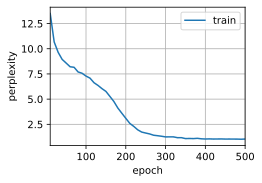

In [17]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

perplexity 1.5, 27888.6 character/second cpu
time traveller smiled rfale thethat is jeatt be so expensivel to
travellerit s against reason said filbywhat be socl sion an


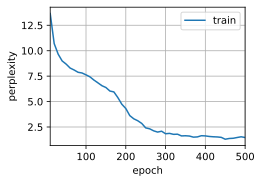

In [18]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True)

## Summary

We can train RNN-based language models to generate text following the user-provided text prefix. 
A simple RNN language model consists of input encoding, RNN modeling, and output generation.
During training, gradient clipping can mitigate the problem of exploding gradients but does not address the problem of vanishing gradients. In the experiment, we implemented a simple RNN language model and trained it with gradient clipping on sequences of text, tokenized at the character level. By conditioning on a prefix, we can use a language model to generate likely continuations, which proves useful in many applications, e.g., autocomplete features.